In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(modelr)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.1”

Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
Warning message:
“package ‘ggplot2’ was built under R version 4.2.

In [2]:
zm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"


#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
zm_input <- here(zm_working_dir,"00.data/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
zm_meta <- here(zm_working_dir,"00.data/Zm.leaf_annot.V4.meta.final.txt")
zm_gene <- here(zm_working_dir,"00.data/Zm.markers.leaf.txt")
zm_gene_DA <- here(zm_working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

zm_meta_data <- read.delim(zm_meta)
zm_gene_markers <- read.delim(zm_gene)
zm_gene_markers <- zm_gene_markers  %>%
    arrange(type)

zm_all_markers <- zm_gene_markers$geneID

zm_raw_cpm_counts_all_genes <- read_delim(zm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

zm_merged_meta_cpm_information <- left_join(zm_meta_data, zm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(Zm_v4_annot, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
zm_merged_meta_cpm_information_copied <- zm_merged_meta_cpm_information
zm_catch <- zm_merged_meta_cpm_information_copied  %>%
    group_by(Zm_v4_annot) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



zm_caught_values <- as_tibble(zm_catch)
zm_see <- ungroup(zm_merged_meta_cpm_information_copied)
zm_merged_meta_cpm_information_copied<- bind_cols(zm_merged_meta_cpm_information_copied,zm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Zm")  %>% 
    group_by(Zm_v4_annot) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
zm_merged_meta.quant_norm <- zm_merged_meta_cpm_information_copied  %>% 
        group_by(Zm_v4_annot)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(zm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


zm_merged_meta_cpm_information_copied <- bind_cols(zm_merged_meta_cpm_information_copied, zm.quantile_normalized)


Rows: 22253352 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Zm_v4_annot'. You can override using the `.groups` argument.


In [3]:

sb_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/sorghum_bicolor"


sb_input <- here(sb_working_dir,"00.data/sb.gene_accessability.iter_1.scores.txt")
sb_meta <- here("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/sb_annot_v4/Sb.leaf_annot.V4.meta.final.2022-11-14.txt")

sb_gene <- here(sb_working_dir,"00.data/Sb.orthos_from.zm.markers.de_novo.all.leaf.visualize.txt")
sb_gene_DA <- here(sb_working_dir,"00.data/Sbicolorv5.1.gene.bed")
#prefix <- "TEST_SORGHUM_TEST"

sb_meta_data <- read.delim(sb_meta)
sb_gene_markers <- read.delim(sb_gene)
sb_gene_markers <- sb_gene_markers  %>%
    arrange(type)



all_markers <- sb_gene_markers$geneID
sb_raw_cpm_counts_all_genes <- read_delim(sb_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)


sb_merged_meta_cpm_information <- left_join(sb_meta_data, sb_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(sb_v4_annot, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
sb_merged_meta_cpm_information_copied <- sb_merged_meta_cpm_information
sb_catch <- sb_merged_meta_cpm_information_copied  %>%
    group_by(sb_v4_annot) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()


sb_caught_values <- as_tibble(sb_catch)
sb_see <- ungroup(sb_merged_meta_cpm_information_copied)
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied,sb_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Sb")  %>% 
    group_by(sb_v4_annot) %>%  
    mutate(log_cpm  = log(grouped_CPM))

#Apply quantile normalization
sb_merged_meta.quant_norm <- sb_merged_meta_cpm_information_copied  %>% 
        group_by(sb_v4_annot)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

sb.quantile_normalized <- as_tibble(sb_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)

#Combine and re_name
sb_merged_meta_cpm_information_copied <- bind_cols(sb_merged_meta_cpm_information_copied, sb.quantile_normalized)



Rows: 35644015 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'sb_v4_annot'. You can override using the `.groups` argument.


In [4]:
sb.cell_type_accessability <- sb_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, sb_v4_annot, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)


zm.cell_type_accessability <- zm_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, Zm_v4_annot, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    

In [5]:
Sb.Zm.key_file <- read_delim("/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.orthos_from.Zm.key_file.txt", 
                             col_names = c("sb", "zm", "gene_name", "cell_type", "tis"))  %>% 
        distinct()

Rows: 260 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): sb, zm, gene_name, cell_type, tis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
head(zm.cell_type_accessability)

geneID,Zm.bundle_sheath,Zm.companion_cells,Zm.developing_mesophyll,Zm.epidermis,Zm.ground_meristem,Zm.mesophyll,Zm.procambium,Zm.protoderm,Zm.sieve_elements,Zm.stomatal_precursor,Zm.subsidiary_cells,Zm.subsidiary_mother_cells,Zm.unknown
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zm00001eb000010,10.3444020,10.54222,22.70170,6.6979797,10.539442,8.1855535,7.199968,6.3853244,6.223857,8.216387,4.332141,0.00000,0.00000
Zm00001eb000020,3.8572346,10.54222,10.08965,6.0281817,18.204491,3.5282558,0.000000,6.3853244,11.558592,8.216387,10.830352,0.00000,11.27962
Zm00001eb000050,0.7013154,0.00000,0.00000,0.8372475,5.748787,0.5645209,0.000000,0.9823576,2.667367,0.000000,0.000000,0.00000,0.00000
Zm00001eb000060,21.7407770,24.59852,26.48532,27.7966158,9.581311,19.0525815,16.199929,22.3486353,25.784551,8.216387,20.577669,18.53780,22.55923
Zm00001eb000070,10.3444020,13.17778,0.00000,10.8842170,46.469359,7.7621628,21.599905,17.6824367,8.002102,0.000000,11.913388,24.71707,56.39808
Zm00001eb000080,41.7282655,65.88888,26.48532,45.2113631,26.827671,43.0447211,34.199850,38.3119462,51.124540,32.865547,51.985691,24.71707,28.19904


In [7]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "ZmSMXL5")

good_gene_markers <- Sb.Zm.key_file  %>% 
    filter(gene_name %in% good_marker_list)  %>% 
    select(-cell_type, -tis)



In [8]:
final_combined_dataset <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    left_join(., sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    rowwise()  %>% 
    mutate(unique_count = n())

generate_corr_matrix <- final_combined_dataset  %>% 
    select(-sb, -zm, -gene_name, -unique_count)

cell_type_corr_matrix <- cor(generate_corr_matrix)

In [9]:
head(cell_type_corr_matrix)

,Zm.bundle_sheath,Zm.companion_cells,Zm.developing_mesophyll,Zm.epidermis,Zm.ground_meristem,Zm.mesophyll,Zm.procambium,Zm.protoderm,Zm.sieve_elements,Zm.stomatal_precursor,⋯,Sb.companion_cells_sieve_elements,Sb.developing_mesophyll,Sb.epidermis,Sb.ground_meristem,Sb.mesophyll,Sb.phloem,Sb.procambium,Sb.proto_xylem,Sb.protoderm,Sb.unknown.7
Zm.bundle_sheath,1.0000000,0.3508818,0.1865162,0.4387838,0.7953303,0.1841954,0.8058640,0.3447077,0.3109756,0.7942838,⋯,0.3650500,0.2433194,0.2249033,0.2575630,0.2082640,0.2936733,0.4464881,0.2740733,0.2125835,0.3874021
Zm.companion_cells,0.3508818,1.0000000,0.3838004,0.4280641,0.4942347,0.3576213,0.5138049,0.3125746,0.9430676,0.5119515,⋯,0.7689909,0.3460114,0.2157397,0.2481476,0.3107877,0.4742165,0.3416648,0.4320487,0.2327658,0.6838209
Zm.developing_mesophyll,0.1865162,0.3838004,1.0000000,0.5084000,0.6725851,0.9742783,0.1566111,0.4653853,0.3964238,0.4839304,⋯,0.2879638,0.8906655,0.4121475,0.4666553,0.8948669,0.2374697,0.3322245,0.5327125,0.4668282,0.3985797
Zm.epidermis,0.4387838,0.4280641,0.5084000,1.0000000,0.6877596,0.4661476,0.4081364,0.9668809,0.4438674,0.6796390,⋯,0.3843166,0.5345207,0.8472394,0.8279128,0.4898427,0.2647380,0.3305401,0.5950270,0.8076449,0.4169768
Zm.ground_meristem,0.7953303,0.4942347,0.6725851,0.6877596,1.0000000,0.6767137,0.6601037,0.5930471,0.4702657,0.8125693,⋯,0.4926111,0.6544843,0.5166208,0.5448372,0.6372494,0.4005618,0.4697969,0.5824931,0.5305468,0.5656561
Zm.mesophyll,0.1841954,0.3576213,0.9742783,0.4661476,0.6767137,1.0000000,0.1479253,0.4089920,0.3567865,0.4304542,⋯,0.2925140,0.8731281,0.4199960,0.4563010,0.8937157,0.2278240,0.3108784,0.5267988,0.4683120,0.4221902


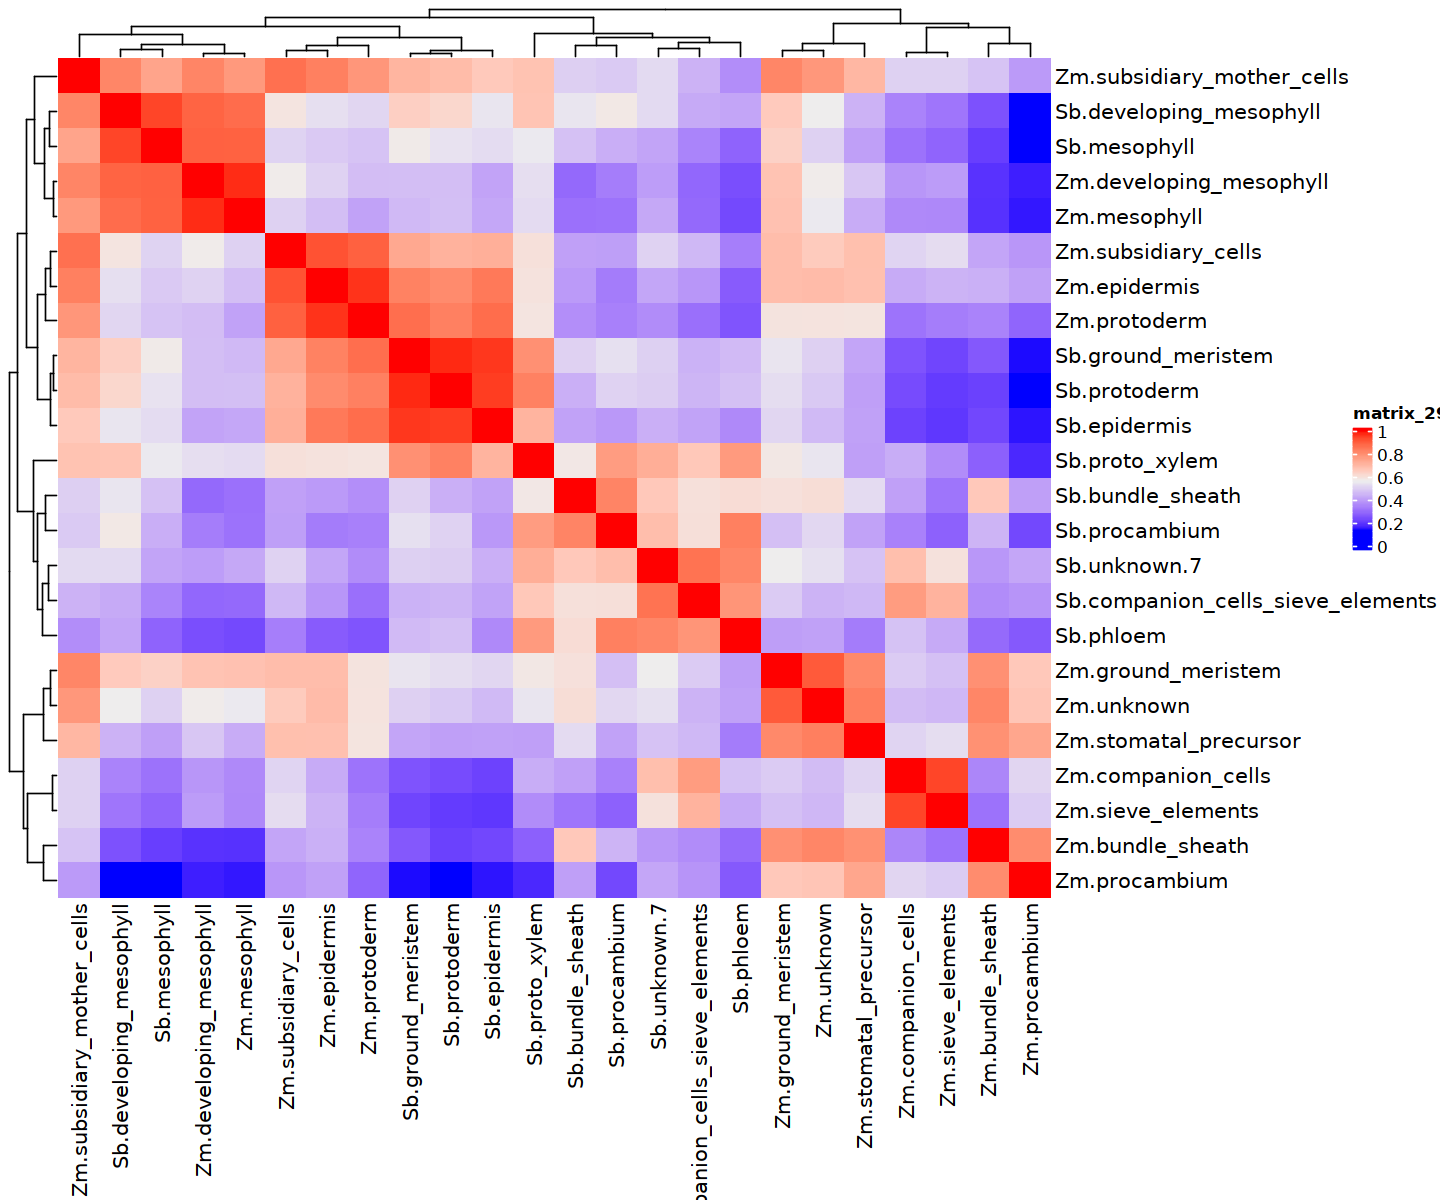

In [79]:
library(ComplexHeatmap)

options(repr.plot.width=12, repr.plot.height=10)
Heatmap(cell_type_corr_matrix)

In [11]:
zm.cell_types <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)
sb.cell_types <- left_join(good_gene_markers, sb.cell_type_accessability, by = c("sb" = "geneID"))  %>% 
    select(-sb, -zm, -gene_name)



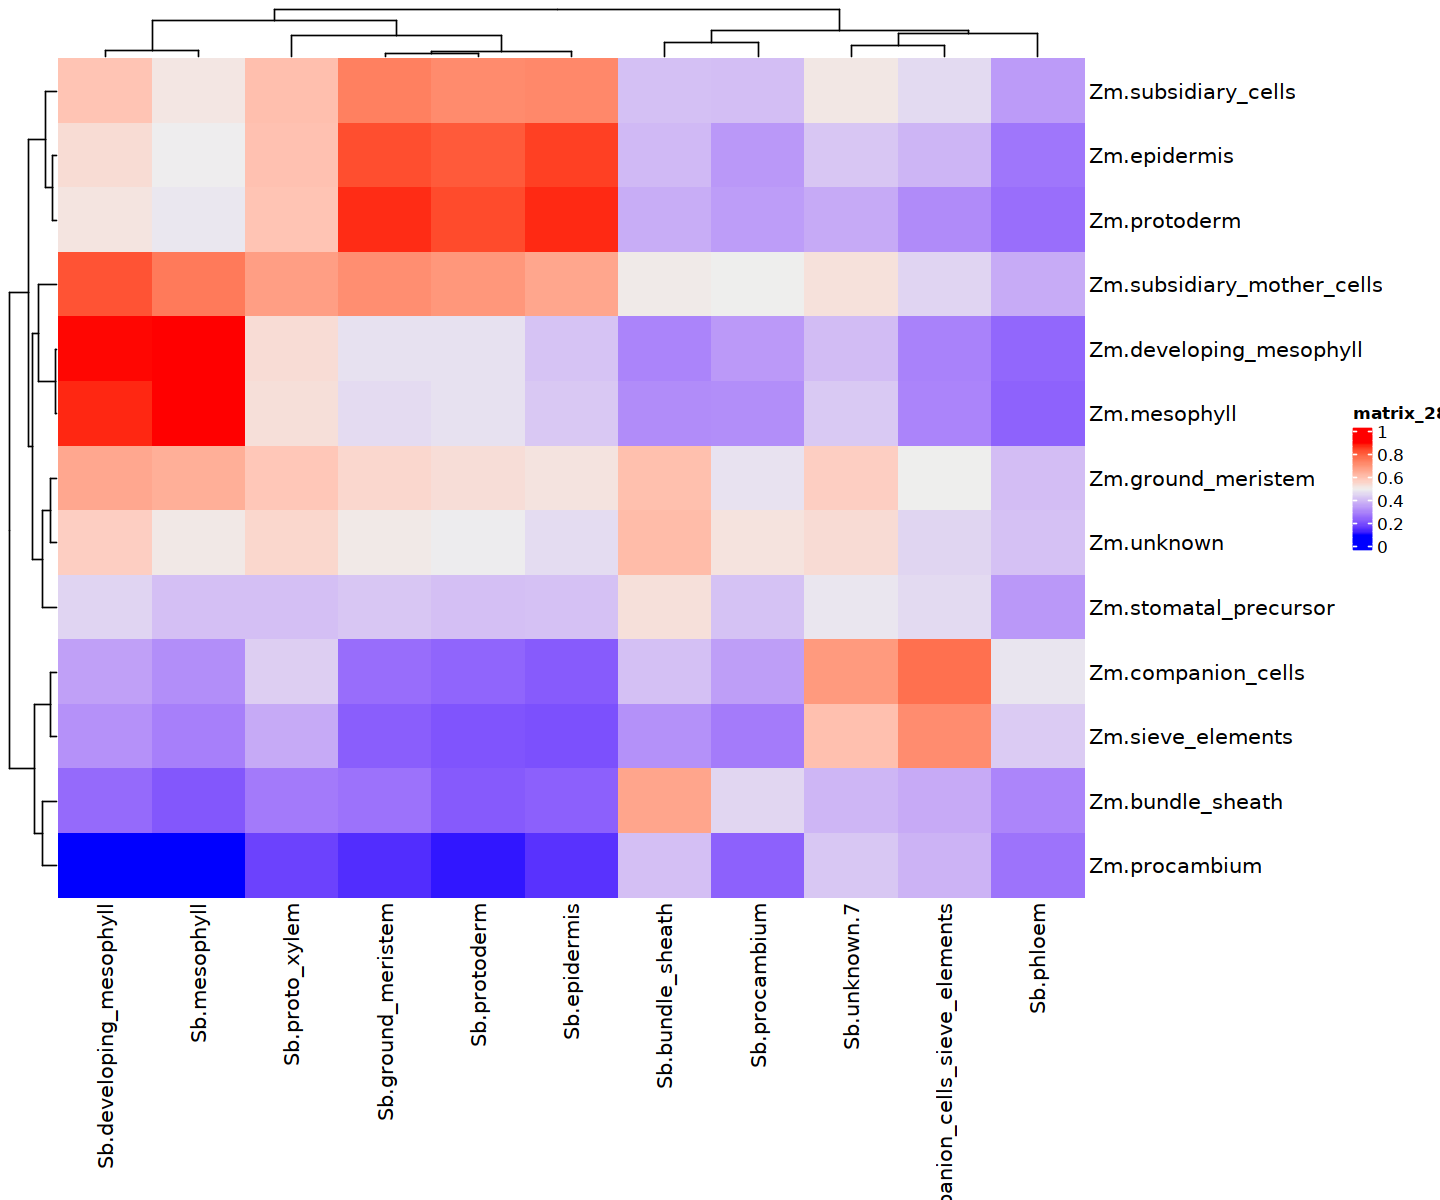

In [78]:
options(repr.plot.width=12, repr.plot.height=10)
sep_corr_matrix <- cor(zm.cell_types, sb.cell_types)
Heatmap(sep_corr_matrix)

In [13]:
## Working now on Single Copy Ortholouges

zm_base <- "Zm"
sb_base <- "Sobic"

Sb_vs_Zm_orthos <- read_delim("/scratch/jpm73279/13.ACR_CNS_analysis/01.analysis/run_orthofinder/2022-06-21_plant_genomes_grass_lineages/OrthoFinder/Results_Jun22/Orthologues/Orthologues_Sbicolor.prot/Sbicolor.prot__v__Zm-B73.prot.tsv") 

#Gross output here that needs to be fixed from orthofinder.
colnames(Sb_vs_Zm_orthos) <- sub("-", "_", colnames(Sb_vs_Zm_orthos), fixed = TRUE)

Rows: 20081 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Orthogroup, Sbicolor.prot, Zm-B73.prot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
Sb_vs_Zm_orthos.fixed <- Sb_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(Sb_count = str_count(Sbicolor.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(Sb_count == 0 & Zm_count == 0) %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    mutate(sb_gene = str_replace(Sbicolor.prot, "\\.[^\\.]*$", ""))
    


In [15]:
sb.zm.single_copy <- Sb_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, zm_gene, sb_gene)

In [16]:
sb.cell_types.all_orthos <- left_join(sb.zm.single_copy, sb.cell_type_accessability, by = c("sb_gene" = "geneID")) %>% 
    drop_na()


zm.cell_types.all_orthos <- left_join(sb.zm.single_copy, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(sb_gene %in% sb.cell_types.all_orthos$sb_gene)


In [17]:
sb.cell_types.all_orthos.final <- sb.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.all_orthos.final <- zm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

In [18]:
dim(zm.cell_types.all_orthos.final)
dim(sb.cell_types.all_orthos.final)

[1] 9349   13

[1] 9349   11

In [19]:
head(sb.cell_types.all_orthos.final)

Sb.bundle_sheath,Sb.companion_cells_sieve_elements,Sb.developing_mesophyll,Sb.epidermis,Sb.ground_meristem,Sb.mesophyll,Sb.phloem,Sb.procambium,Sb.proto_xylem,Sb.protoderm,Sb.unknown.7
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12.600860,9.406383,56.239484,2.571771,8.456038,18.4067212,18.014311,64.816812,30.053183,38.804180,0.000000
18.079495,3.359423,6.461558,15.430626,33.119482,7.3800533,7.584973,22.296983,13.292754,24.958999,7.519325
11.368167,14.109575,15.076968,14.342569,24.428554,5.7303943,24.651162,15.037500,34.676749,37.485591,15.038649
1.369659,1.343769,1.914536,7.962599,2.348899,0.5209449,5.688730,4.666810,2.311783,1.977883,10.025766
52.183996,35.609880,102.188338,133.633175,126.370788,139.3527711,7.584973,9.852155,19.072212,25.995033,77.699688
2.739317,4.031307,10.051312,9.792512,44.159309,7.7273499,5.688730,3.111207,13.870700,43.136685,7.519325


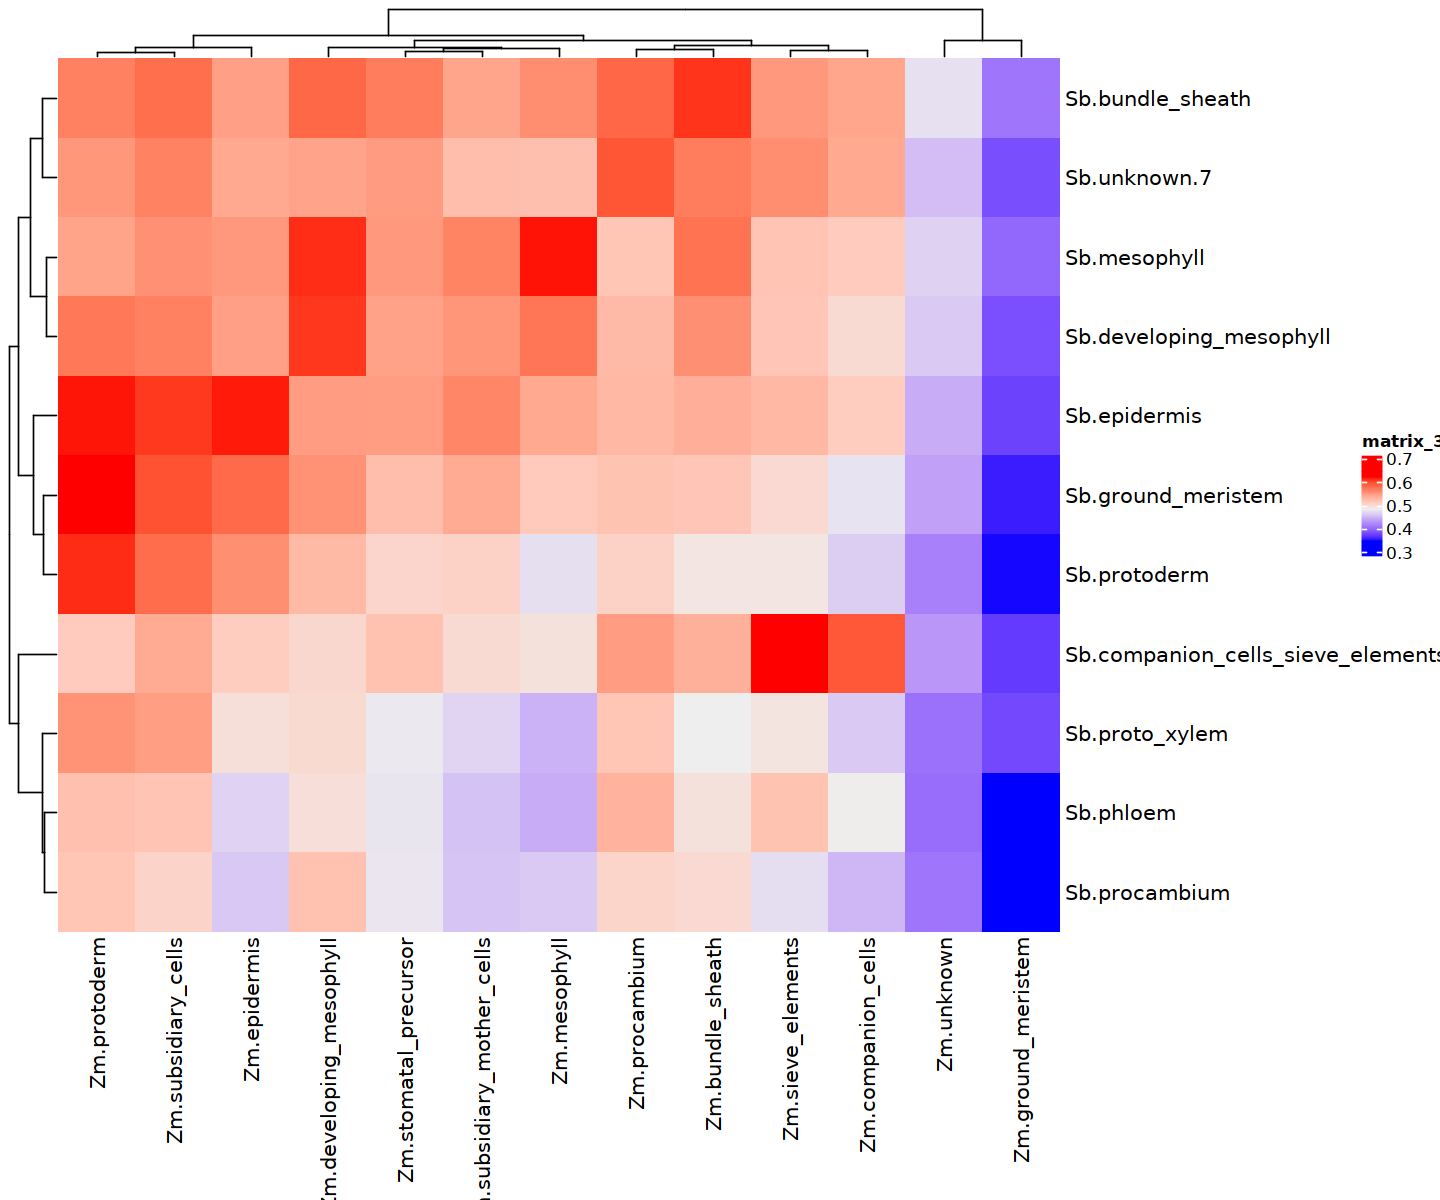

In [20]:
options(repr.plot.width=12, repr.plot.height=10)
all_orthos_corr <- cor((sb.cell_types.all_orthos.final), (zm.cell_types.all_orthos.final))
Heatmap(all_orthos_corr)

# Selecting the 1000-2000 most variable single copy orthos

In [27]:
combined_sb_zm <- full_join(sb.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_sb_zm.subset <- combined_sb_zm  %>% 
    #dplyr::select(-zm_gene, -sb_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, sb_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


In [71]:
combined_sb_zm.subset.mean.var <- combined_sb_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_sb_zm.subset.mean.var)

combined_sb_zm.subset.mean.var.final <- combined_sb_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(8000)

Selecting by resid


In [72]:
combined_sb_zm.subset.mean.var.final.split <- combined_sb_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "sb_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, sb_gene)

In [73]:
sb.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split, sb.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_sb_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -sb_gene)  %>% 
    replace(is.na(.), 0)

Joining, by = c("Orthogroup", "zm_gene", "sb_gene")
Joining, by = c("Orthogroup", "zm_gene", "sb_gene")


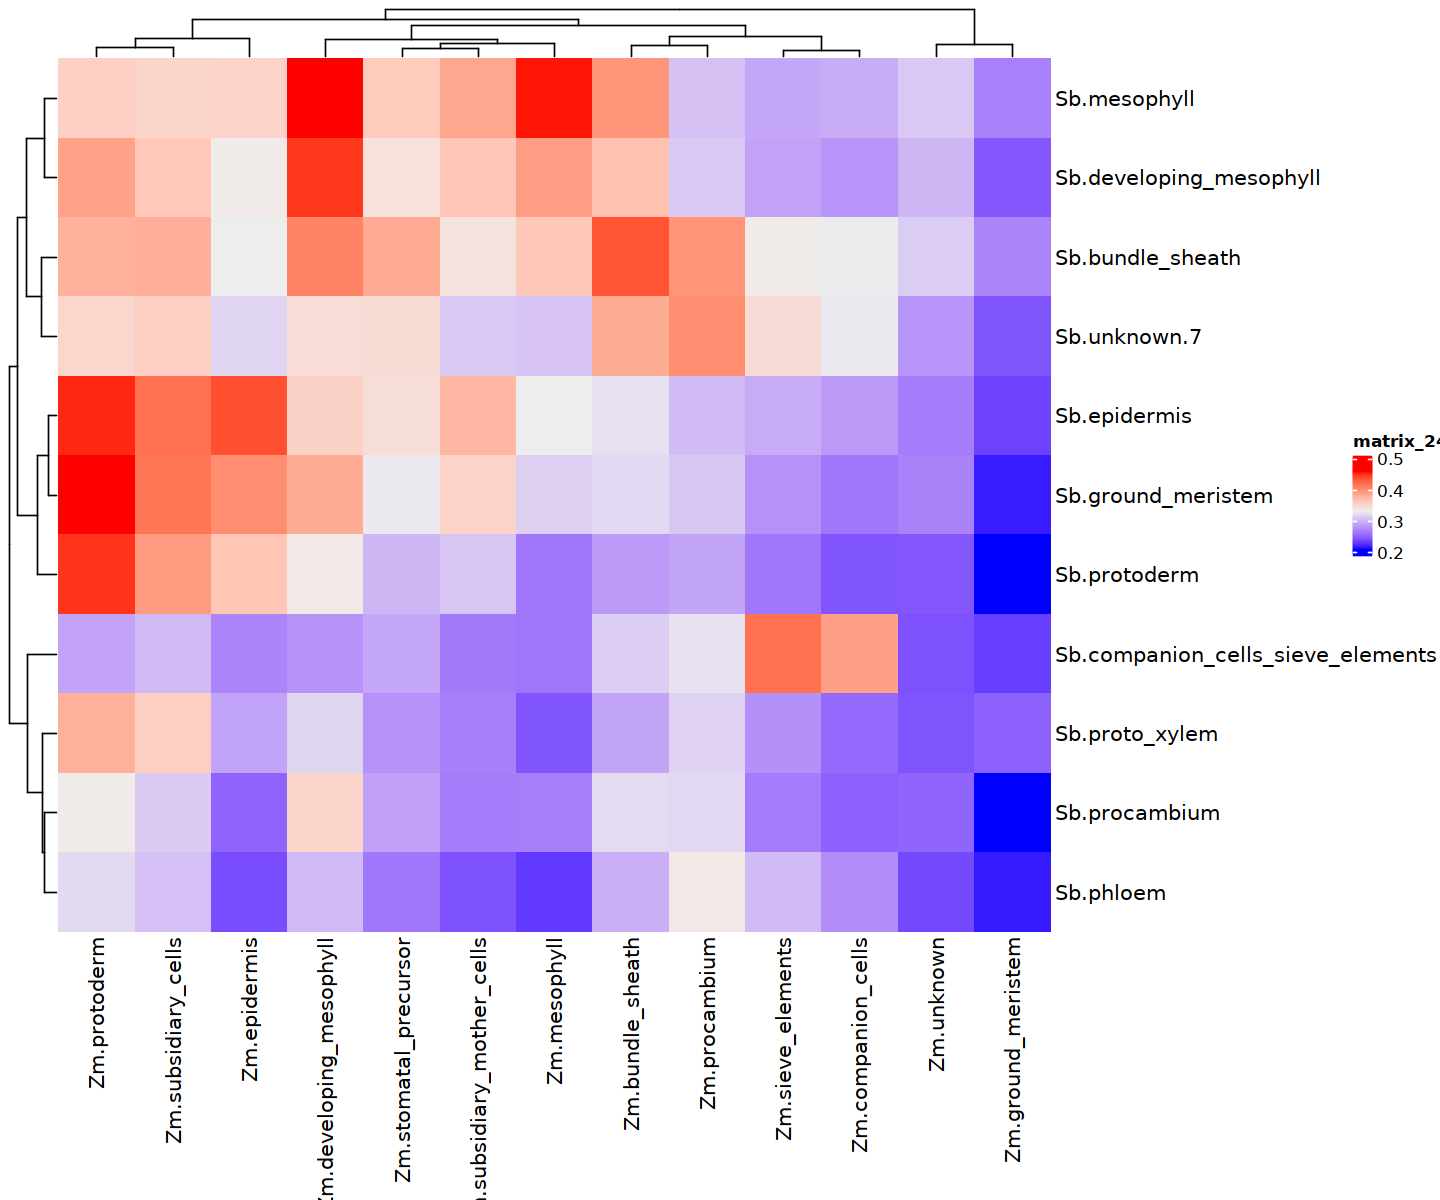

In [74]:
options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final)

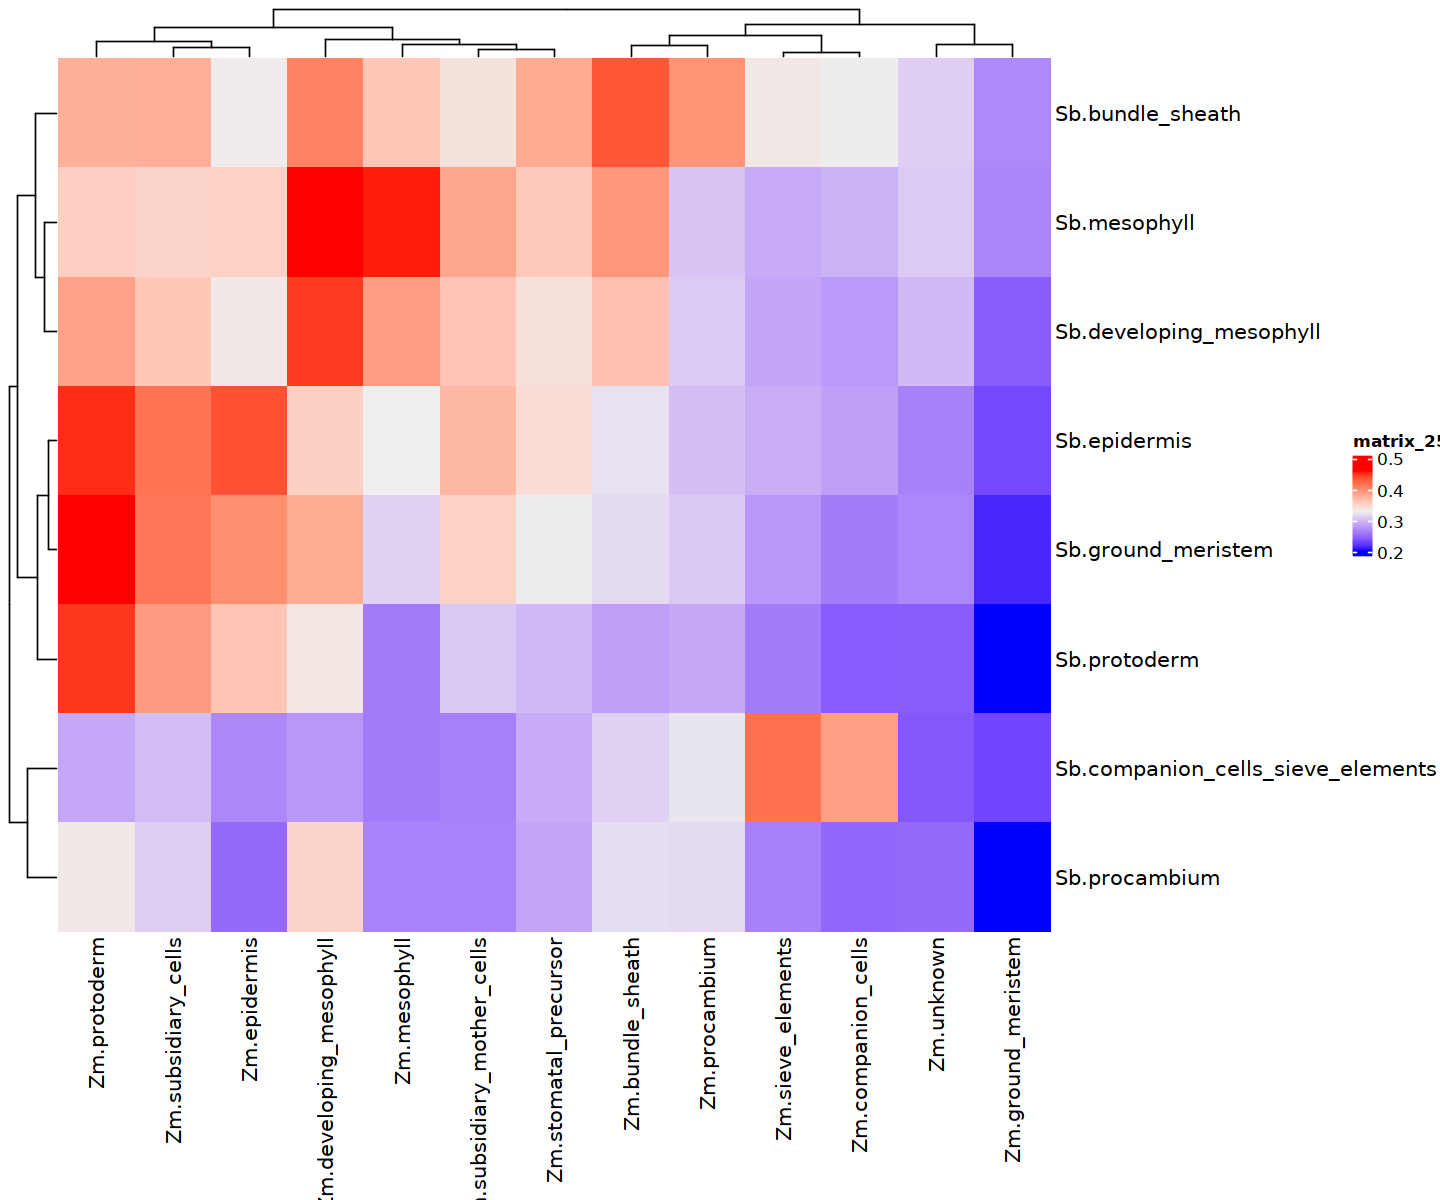

In [75]:
sb.cell_types.var_orthos.final.sub_select <- sb.cell_types.var_orthos.final  %>% 
    select(-Sb.proto_xylem, -Sb.unknown.7, -Sb.phloem)

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final

options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
Heatmap(var.orthos.final)


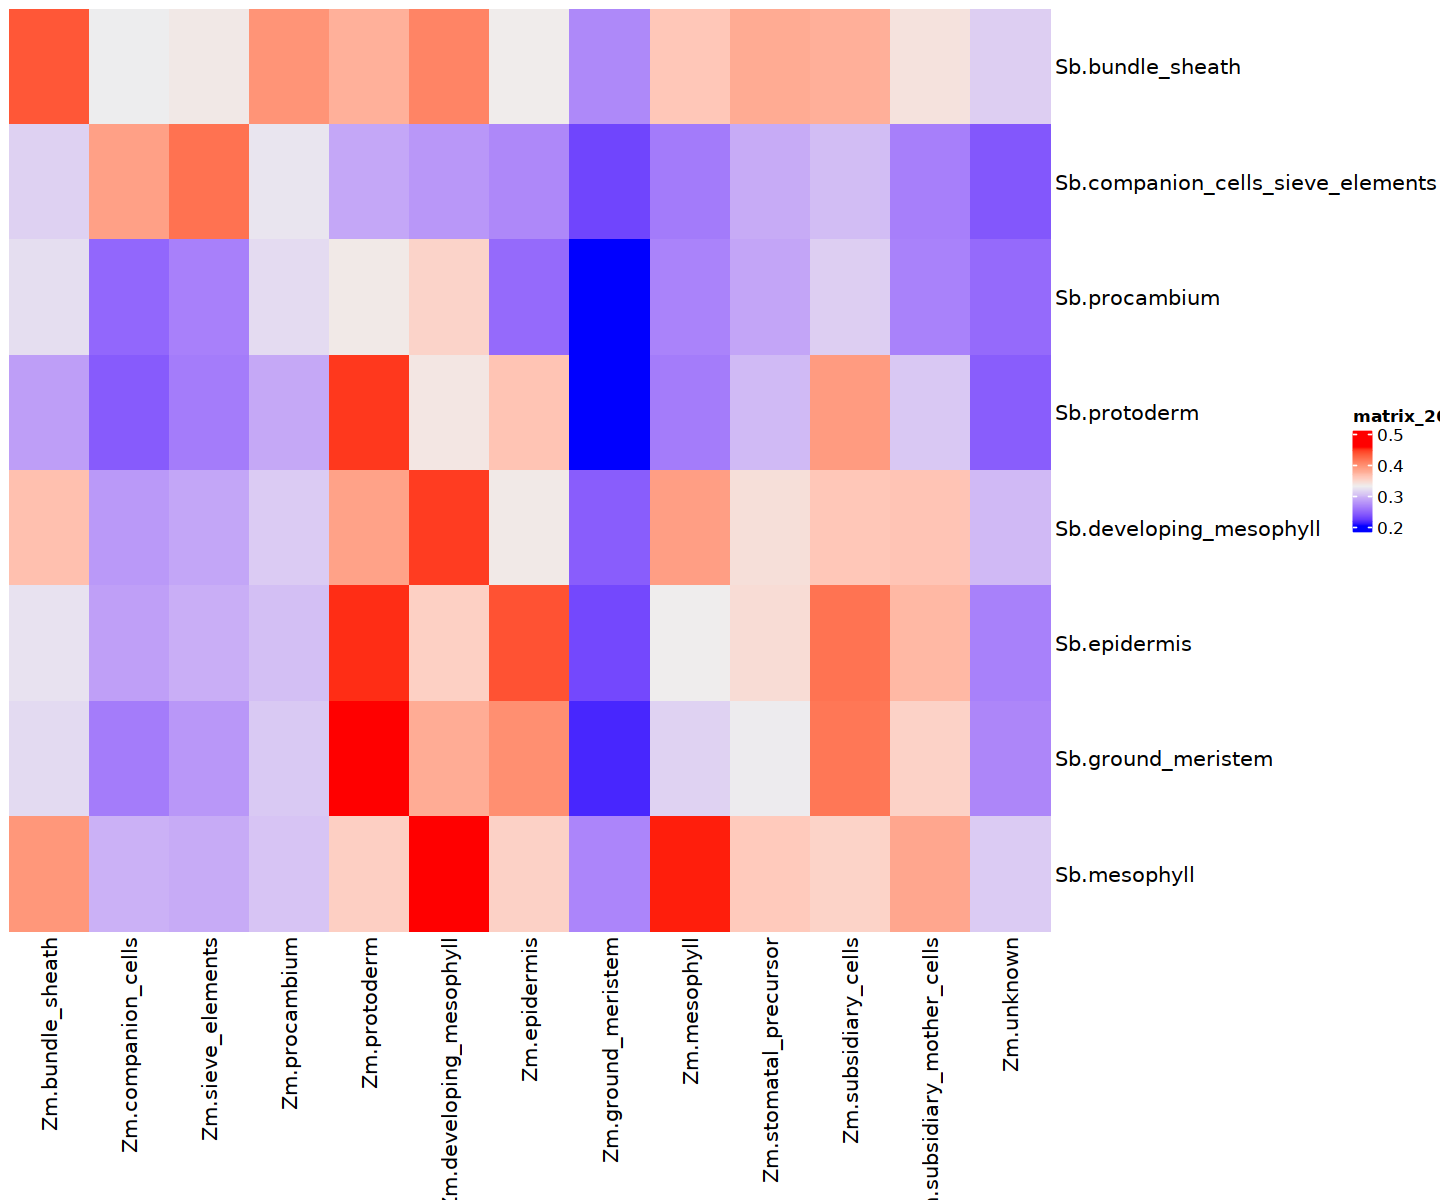

In [76]:
## Sb Vs Zm Ordering the Rows and Columns by cell type


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
#Heatmap(var.orthos.final)

sb_order <- c('Sb.bundle_sheath',
'Sb.companion_cells_sieve_elements',
'Sb.procambium',
'Sb.protoderm',
'Sb.developing_mesophyll',
'Sb.epidermis',
'Sb.ground_meristem',
'Sb.mesophyll')

zm_order <- c('Zm.bundle_sheath',
'Zm.companion_cells',
'Zm.sieve_elements',
'Zm.procambium',
'Zm.protoderm',
'Zm.developing_mesophyll',
'Zm.epidermis',
'Zm.ground_meristem',
'Zm.mesophyll',
'Zm.stomatal_precursor',
'Zm.subsidiary_cells',
'Zm.subsidiary_mother_cells',
'Zm.unknown')



Heatmap(var.orthos.final,
        row_order = sb_order,
        column_order = zm_order)

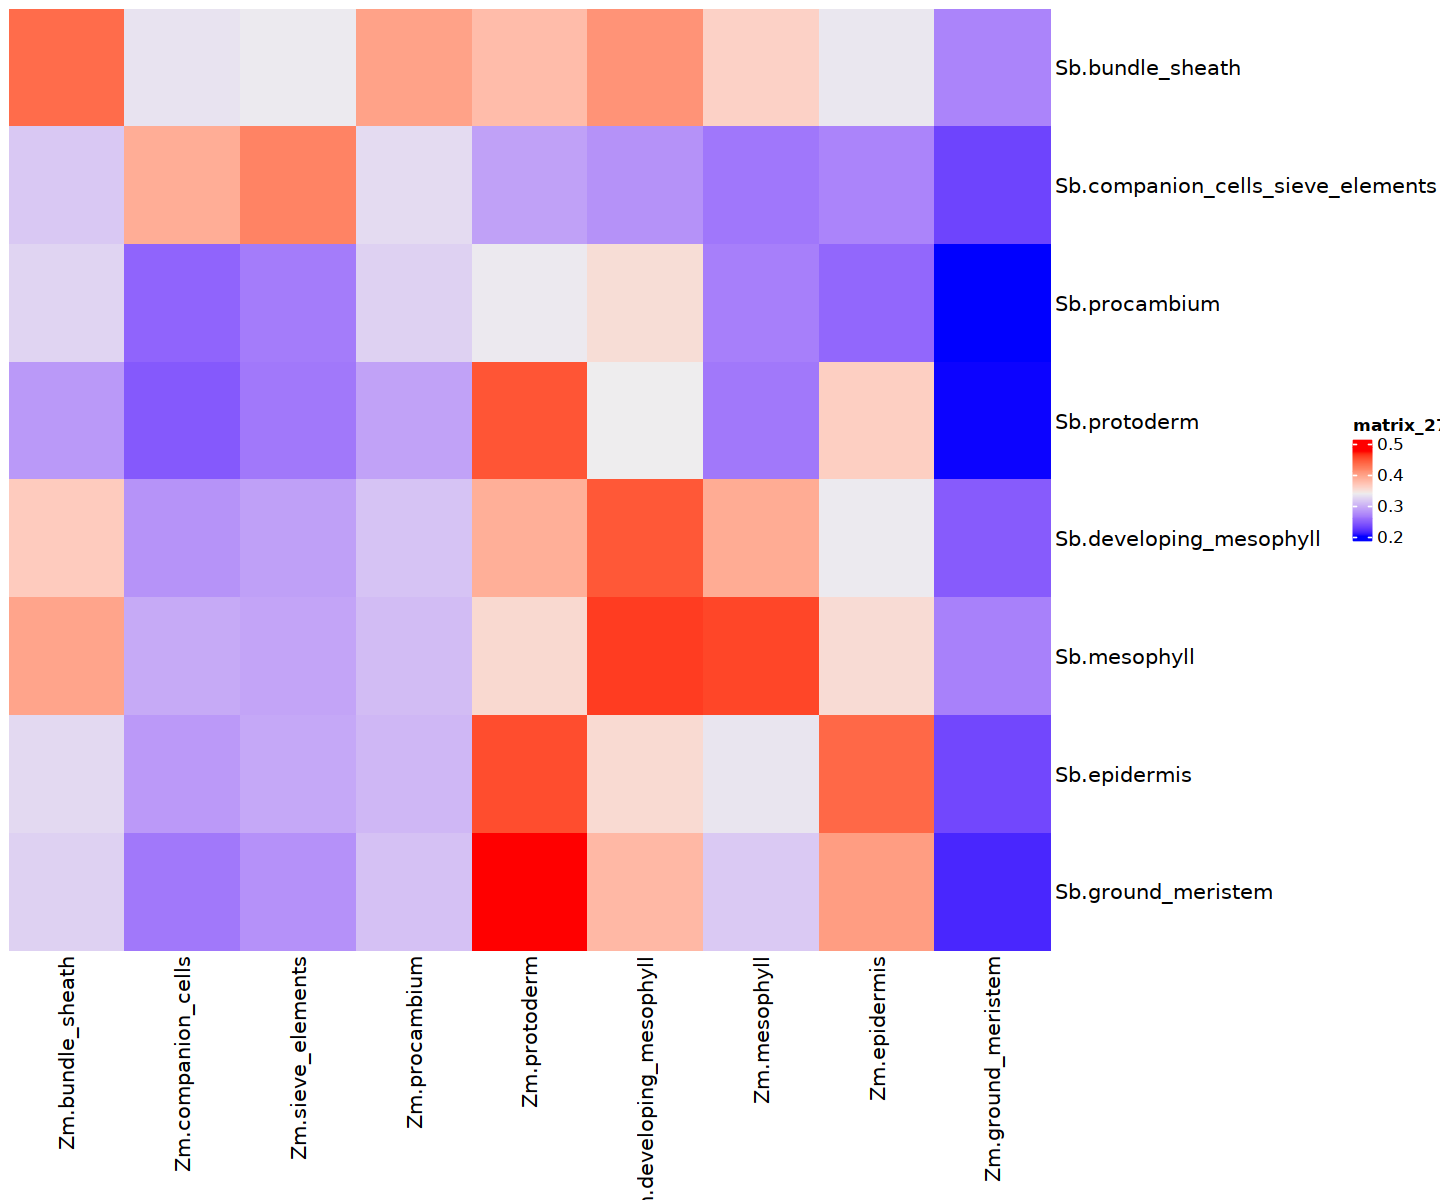

In [77]:
sb.cell_types.var_orthos.final.sub_select <- sb.cell_types.var_orthos.final  %>% 
    select(-Sb.proto_xylem, -Sb.unknown.7, -Sb.phloem)

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final  %>% 
    select(-Zm.stomatal_precursor, -Zm.subsidiary_cells, -Zm.subsidiary_mother_cells, -Zm.unknown)


sb_order <- c('Sb.bundle_sheath',
'Sb.companion_cells_sieve_elements',
'Sb.procambium',
'Sb.protoderm',
'Sb.developing_mesophyll',
'Sb.mesophyll',
'Sb.epidermis',
'Sb.ground_meristem'
)

zm_order <- c('Zm.bundle_sheath',
'Zm.companion_cells',
'Zm.sieve_elements',
'Zm.procambium',
'Zm.protoderm',
'Zm.developing_mesophyll',
'Zm.mesophyll',
'Zm.epidermis',
'Zm.ground_meristem')


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
Heatmap(var.orthos.final,
        row_order = sb_order,
        column_order = zm_order)

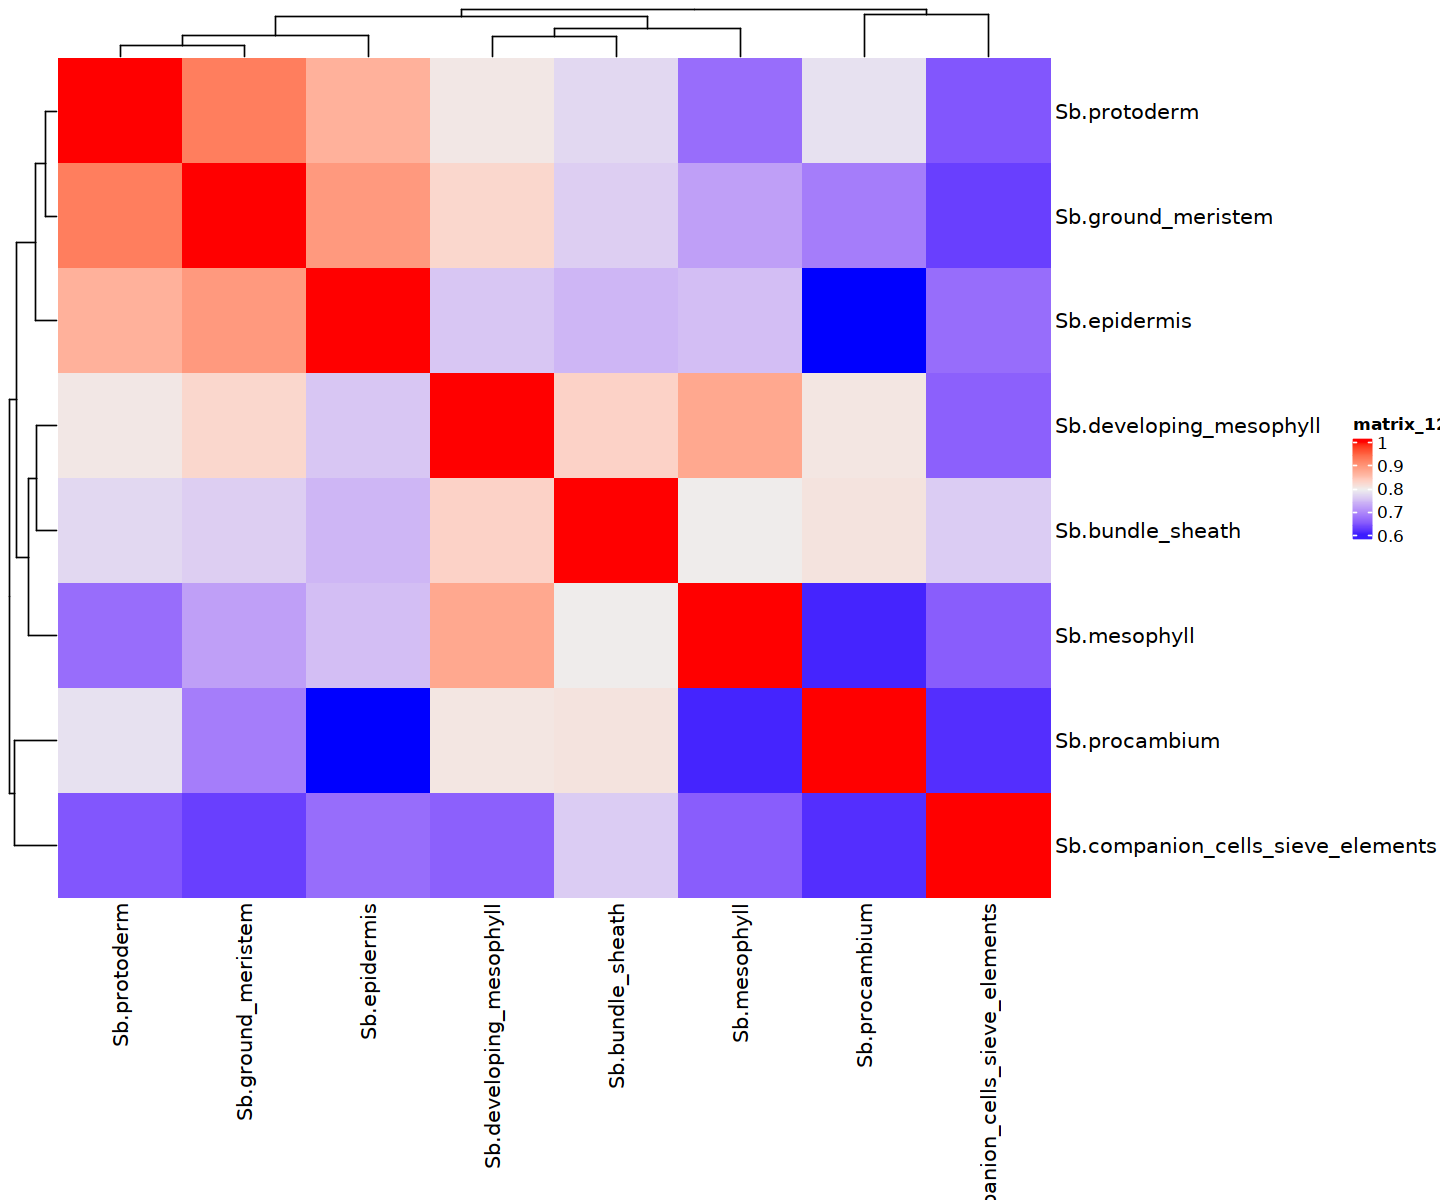

In [39]:
var.orthos.final <- cor((sb.cell_types.var_orthos.final.sub_select), (sb.cell_types.var_orthos.final.sub_select))
Heatmap(var.orthos.final)

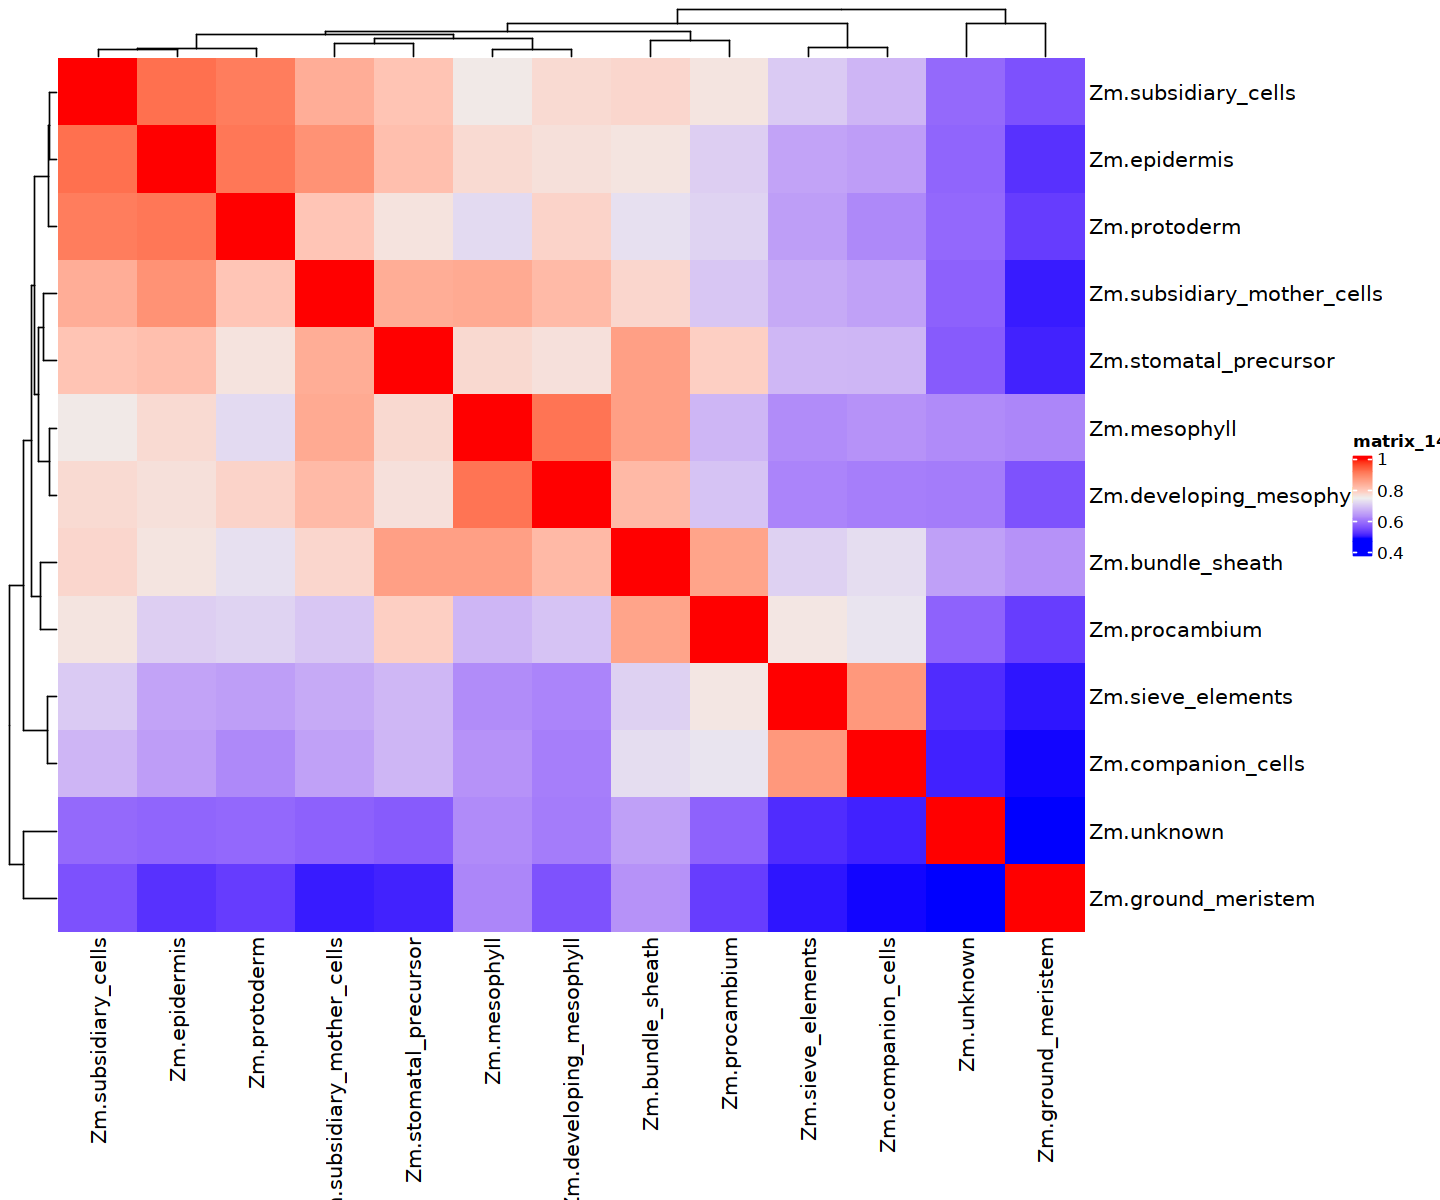

In [41]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm.cell_type_heatmaps <- Heatmap(var.orthos.final)
zm.cell_type_heatmaps

In [35]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm.cell_type_heatmaps <- Heatmap(var.orthos.final)

pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm.ct_correlation.pdf")
zm.cell_type_heatmaps
dev.off()
zm.cell_type_heatmaps

ERROR: Error in pdf(file = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm.ct_correlation.pdf"): cannot open file '/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm.ct_correlation.pdf'


In [35]:
colnames(zm_meta_data)

[1] "cellID"                       "total"                       
 [3] "tss"                          "acrs"                        
 [5] "ptmt"                         "nSites"                      
 [7] "log10nSites"                  "pTSS"                        
 [9] "FRiP"                         "pOrg"                        
[11] "tss_z"                        "acr_z"                       
[13] "sites_z"                      "qc_check"                    
[15] "background"                   "cellbulk"                    
[17] "is_cell"                      "sampleID"                    
[19] "umap1"                        "umap2"                       
[21] "doubletscore"                 "d.type"                      
[23] "ptmt_ratio"                   "LouvainClusters"             
[25] "Zm_v4_annot"                  "Zm_v4_annot.subcluster_annot"
[27] "Zm.vasculature_lc"            "Zm.epidermis_lc"             
[29] "Zm.mesophyll_lc"              "v4_annotation_n"             
[31] "total_cell_count"

In [ ]:
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)
total_tn5 <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log(total))) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


doublet_score <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = doubletscore)) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


total_tn5 + doublet_score


In [ ]:
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)
total_tn5 <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log(tss))) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


doublet_score <- ggplot(zm_meta_data, aes(x = V3_annotation_n, y = log10nSites)) + 
    geom_violin() + 
    geom_boxplot(width = .1) +
      coord_flip()


total_tn5 + doublet_score


In [ ]:
marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    
    
        
    merged_meta_cpm_information <- left_join(meta_data, loaded_sparse_matric, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()

    
    caught_values <- as_tibble(catch)
    sb_merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        rename(grouped_CPM = value)
    
    
    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(sb_v4_annot)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        rename("quant_norm_cpm" = value)

    #Combine and re_name
    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized)  %>% 
        ungroup()  %>% 
        select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)


    
    meta_obj[["corr_matrix"]] <- merged_meta_cpm_information_copied
    
    return(meta_obj)
}

In [ ]:

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(!!sym(cluster_name), geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(!!sym(cluster_name)) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    group_by(!!sym(cluster_name)) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    